In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import lime
import lime.lime_tabular
import shap
import time
import sys
sys.path.append('../../wrapper')
import xgboost
from xgboost import XGBClassifier
from collections import Counter

import os
import glob
import mglearn
import sklearn
import sklearn.datasets
from numpy import random

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, cohen_kappa_score, classification_report
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn import pipeline
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

from string import ascii_letters
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
shap.initjs()

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
y_valid = pd.read_csv("y_valid_Mo1.csv", sep='\t', index_col=0)
X_valid_selected = pd.read_csv("X_valid_selected_Mo1.csv", sep='\t', index_col=0)
X_traintest_selected = pd.read_csv("X_traintest_selected_Mo1.csv", sep='\t', index_col=0)
y_traintest_sampled = pd.read_csv("y_traintest_sampled_Mo1.csv", sep='\t', index_col=0)

In [3]:
params = {'max_depth':20, 'n_estimators':500,
          'objective': 'multi:softmax', 'num_class': 2
}

params['max_depth'] = 9
params['min_child_weight'] = 5
params['n_estimators'] = 100
params['subsample'] = .7
params['colsample_bytree'] = .9

In [4]:
xgb_traintest = xgboost.DMatrix(X_traintest_selected, label=y_traintest_sampled)
xgb_valid = xgboost.DMatrix(X_valid_selected, label=y_valid)

In [5]:
xgb = xgboost.train(params, xgb_traintest, 100)

In [6]:
xgb_pred = xgb.predict(xgb_valid)

In [7]:
Mo1_tp = y_valid.index[(y_valid==1).iloc[:, 0] & (xgb_pred==1)].tolist()
Mo1_fp = y_valid.index[(y_valid==0).iloc[:, 0] & (xgb_pred==1)].tolist()
Mo1_tn = y_valid.index[(y_valid==0).iloc[:, 0] & (xgb_pred==0)].tolist()
Mo1_fn = y_valid.index[(y_valid==1).iloc[:, 0] & (xgb_pred==0)].tolist()

In [8]:
Mo1_fp_samples = random.choice(Mo1_fp, len(Mo1_tp))
Mo1_tn_samples = random.choice(Mo1_tn, len(Mo1_fn))

In [9]:
Mo1_pos = []
Mo1_pos.extend(Mo1_tp)
Mo1_pos.extend(Mo1_fp_samples)
Mo1_neg = []
Mo1_neg.extend(Mo1_fn)
Mo1_neg.extend(Mo1_tn_samples)
Mo1_all = []
Mo1_all.extend(Mo1_pos)
Mo1_all.extend(Mo1_neg)

In [110]:
xgb_valid_Mo1_tp = xgboost.DMatrix(X_valid_selected.iloc[Mo1_tp,:], label=y_valid.loc[Mo1_tp])
xgb_valid_Mo1_fp = xgboost.DMatrix(X_valid_selected.iloc[Mo1_fp_samples,:], label=y_valid.loc[Mo1_fp_samples])
xgb_valid_Mo1_tn = xgboost.DMatrix(X_valid_selected.iloc[Mo1_tn_samples,:], label=y_valid.loc[Mo1_tn_samples])
xgb_valid_Mo1_fn = xgboost.DMatrix(X_valid_selected.iloc[Mo1_fn,:], label=y_valid.loc[Mo1_fn])

In [111]:
shap_values_xgb_Mo1_tp = xgb.predict(xgb_valid_Mo1_tp, pred_contribs=True)
shap_values_xgb_Mo1_fp = xgb.predict(xgb_valid_Mo1_fp, pred_contribs=True)
shap_values_xgb_Mo1_tn = xgb.predict(xgb_valid_Mo1_tn, pred_contribs=True)
shap_values_xgb_Mo1_fn = xgb.predict(xgb_valid_Mo1_fn, pred_contribs=True)

In [112]:
xgb_valid_Mo1_pos = xgboost.DMatrix(X_valid_selected.iloc[Mo1_pos,:], label=y_valid.loc[Mo1_pos])
xgb_valid_Mo1_neg = xgboost.DMatrix(X_valid_selected.iloc[Mo1_neg,:], label=y_valid.loc[Mo1_neg])
xgb_valid_Mo1_all = xgboost.DMatrix(X_valid_selected.iloc[Mo1_all,:], label=y_valid.loc[Mo1_all])

shap_values_xgb_Mo1_pos = xgb.predict(xgb_valid_Mo1_pos, pred_contribs=True)
shap_values_xgb_Mo1_neg = xgb.predict(xgb_valid_Mo1_neg, pred_contribs=True)
shap_values_xgb_Mo1_all = xgb.predict(xgb_valid_Mo1_all, pred_contribs=True)

In [106]:
force_plot(shap_values_xgb_Mo1_tp[:, 1, :], X_valid_selected.iloc[Mo1_tp,:])

In [107]:
force_plot(shap_values_xgb_Mo1_fp[:, 1, :], X_valid_selected.iloc[Mo1_fp,:])

In [29]:
force_plot(shap_values_xgb_Mo1_fn[:, 1, :], X_valid_selected.iloc[Mo1_fn,:])

In [30]:
force_plot(shap_values_xgb_Mo1_tn[:, 1, :], X_valid_selected.iloc[Mo1_tn,:])

In [31]:
force_plot(shap_values_xgb_Mo1_pos[:, 1, :], X_valid_selected.iloc[Mo1_pos,:])

In [37]:
force_plot(shap_values_xgb_Mo1_neg[:, 1, :], X_valid_selected.iloc[Mo1_neg,:])

In [42]:
force_plot(shap_values_xgb_Mo1_all[:, 1, :], X_valid_selected.iloc[Mo1_all,:])

In [43]:
print("TP max=",np.sum(shap_values_xgb_Mo1_tp[:, 1, :], axis=1).max(), "min=", np.sum(shap_values_xgb_Mo1_tp[:, 1, :], axis=1).min())
print("FP max=",np.sum(shap_values_xgb_Mo1_fp[:, 1, :], axis=1).max(), "min=", np.sum(shap_values_xgb_Mo1_fp[:, 1, :], axis=1).min())
print("FN max=",np.sum(shap_values_xgb_Mo1_fn[:, 1, :], axis=1).max(), "min=", np.sum(shap_values_xgb_Mo1_fn[:, 1, :], axis=1).min())
print("TN max=",np.sum(shap_values_xgb_Mo1_tn[:, 1, :], axis=1).max(), "min=", np.sum(shap_values_xgb_Mo1_tn[:, 1, :], axis=1).min())

TP max= 4.82413 min= 0.109151
FP max= 3.79357 min= -0.552733
FN max= 1.43624 min= -4.04972
TN max= -1.58089 min= -6.30057


In [138]:
### Given explanation, predict TP(0), FP(1), FN(2), TN(3)
feature_tp = pd.DataFrame(shap_values_xgb_Mo1_tp[:, 1, :][:, :-1])
feature_fp = pd.DataFrame(shap_values_xgb_Mo1_fp[:, 1, :][:, :-1])
feature_fn = pd.DataFrame(shap_values_xgb_Mo1_fn[:, 1, :][:, :-1])
feature_tn = pd.DataFrame(shap_values_xgb_Mo1_tn[:, 1, :][:, :-1])
feature_all = pd.concat((feature_tp, feature_fp, feature_fn, feature_tn)).reset_index(drop=True)

labels = np.repeat([0, 1, 2, 3], [feature_tp.shape[0], feature_fp.shape[0], feature_fn.shape[0], feature_tn.shape[0]])

In [139]:
feature_all

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.006987,0.116347,0.659501,0.242184,0.278103,0.143198,-0.056387,0.261502,0.025955,0.210272,...,0.631818,-0.083045,0.089955,0.071385,0.110759,-0.007478,0.762045,-0.007275,0.203093,0.382158
1,0.005084,0.042727,1.078923,-0.041985,0.286565,-0.106696,-0.075635,-0.020980,0.026779,0.146780,...,0.520261,-0.055528,-0.029931,0.128049,0.158531,0.452357,0.281148,-0.013122,0.395548,0.922203
2,-0.000324,0.360827,1.337481,-0.009467,0.147876,0.003398,-0.064515,-0.013316,-0.182737,0.027540,...,0.791385,-0.049782,0.221777,-0.008658,-0.186613,0.235627,-0.147942,0.840335,-0.008725,0.137014
3,0.455341,-0.034404,-0.367564,0.001868,0.013425,0.009697,3.692264,-0.000809,-0.010825,-0.045215,...,0.176381,-0.052302,0.134752,0.102162,-0.086321,-0.102432,0.363715,0.237375,0.473374,-0.113083
4,0.012955,-0.103931,0.802410,0.206155,0.164235,0.144591,-0.054860,0.182567,0.146148,0.179530,...,0.525415,-0.143338,0.055993,0.065437,0.061554,0.036182,0.708942,-0.023483,0.118784,0.360464
5,0.003764,-0.003089,0.851487,0.200781,0.313522,0.043000,-0.052852,0.233560,0.111573,0.188390,...,0.585600,-0.088117,0.078668,0.073534,0.102397,0.103744,0.832714,-0.018764,0.167613,0.818428
6,-0.022104,-0.041562,1.596619,0.004524,-0.015326,0.009753,-0.094013,-0.004826,0.024823,0.125610,...,0.275265,-0.021597,0.271730,0.889960,0.643090,0.428367,-0.080431,0.106631,-0.025276,-0.053687
7,-0.147488,-0.083599,1.586626,-0.026063,0.051810,-0.029399,-0.092063,-0.011385,-0.001460,-0.071372,...,0.233932,-0.059178,0.331840,0.734146,0.820919,0.339611,-0.124436,0.328202,0.077170,0.268453
8,0.241623,-0.038476,0.599514,-0.001256,0.064889,0.055691,2.940913,-0.004020,0.006371,0.004377,...,0.247503,-0.064539,0.076213,0.125197,0.100826,0.058996,-0.000656,0.128575,0.157992,-0.381535
9,0.749151,-0.016655,-0.411293,0.003903,0.080062,0.009966,3.506027,-0.000475,0.007451,-0.009094,...,0.152577,-0.089051,0.044463,0.024978,0.054897,0.132488,-0.224774,0.368513,0.527084,-0.286958


In [140]:
X_train, X_test, y_train, y_test = train_test_split(feature_all, labels, test_size=0.2, random_state=0)

In [141]:
exp_train = xgboost.DMatrix(X_train, label=y_train)
exp_test = xgboost.DMatrix(X_test, label=y_test)

In [142]:
params = {'max_depth':20, 'n_estimators':500,
          'objective': 'multi:softmax', 'num_class': 4
}

params['max_depth'] = 9
params['min_child_weight'] = 5
params['n_estimators'] = 100
params['subsample'] = .7
params['colsample_bytree'] = .9

In [143]:
exp = xgboost.train(params, exp_train, 100)

In [144]:
def confusion_matrix_plot(X_test, y_test, clf):
    plt.rcParams.update({'font.size': 16})
    plt.rcParams.update({'axes.titlesize': 16})
    plt.rcParams.update({'axes.labelsize': 16})
    plt.rcParams.update({'ytick.labelsize': 16})
    plt.rcParams.update({'xtick.labelsize': 16})
    f, ax = plt.subplots(figsize=(6, 6))
    target_names = ['TP', 'FP', 'FN', 'TN']
    scores_image = mglearn.tools.heatmap(
        confusion_matrix(y_test, clf.predict(X_test)), xlabel='Predicted label',
        ylabel='True label', xticklabels=target_names,
        yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
    plt.title("Confusion matrix")
    plt.gca().invert_yaxis()

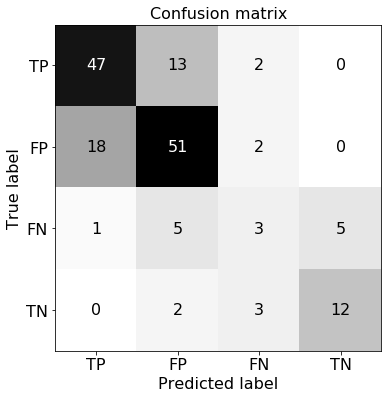

In [145]:
confusion_matrix_plot(exp_test, y_test, exp)

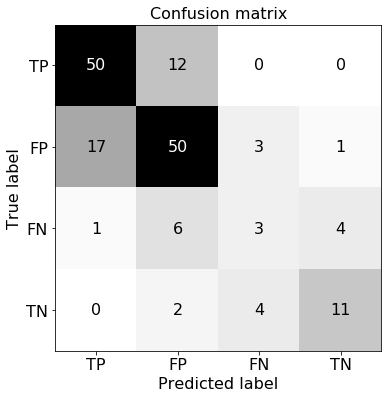

In [73]:
confusion_matrix_plot(exp_test, y_test, exp)

In [13]:
import warnings
from scipy.stats import gaussian_kde
import sys
# sys.path.append("iml_master/iml_test")
sys.path.insert(0, "iml_master")

import iml_test, iml_test.links
from iml_test import Instance, Model, visualize
from iml_test.explanations import AdditiveExplanation
from iml_test.links import IdentityLink
from iml_test.datatypes import DenseData
import numpy as np

def force_plot(shap_values, features=None, feature_names=None, out_names=None, link="identity",
               plot_cmap="RdBu"):
    """ Visualize the given SHAP values with an additive force layout. """

    assert not type(shap_values) == list, "The shap_values arg looks looks multi output, try shap_values[i]."

    link = iml_test.links.convert_to_link(link)
    if type(shap_values) != np.ndarray:
        return iml_test.visualize(shap_values)

    # convert from a DataFrame or other types
    if str(type(features)) == "<class 'pandas.core.frame.DataFrame'>":
        if feature_names is None:
            feature_names = list(features.columns)
        features = features.as_matrix()
    elif str(type(features)) == "<class 'pandas.core.series.Series'>":
        if feature_names is None:
            feature_names = list(features.index)
        features = features.as_matrix()
    elif str(type(features)) == "list":
        if feature_names is None:
            feature_names = features
        features = None
    elif features is not None and len(features.shape) == 1 and feature_names is None:
        feature_names = features
        features = None

    if len(shap_values.shape) == 1:
        shap_values = np.reshape(shap_values, (1, len(shap_values)))

    if out_names is None:
        out_names = ["output value"]

    if shap_values.shape[0] == 1:
        if feature_names is None:
            feature_names = ["Feature " + str(i) for i in range(shap_values.shape[1] - 1)]
        if features is None:
            features = ["" for _ in range(len(feature_names))]
        if type(features) == np.ndarray:
            features = features.flatten()

        instance = Instance(np.zeros((1, len(feature_names))), features)
        e = AdditiveExplanation(
            shap_values[0, -1],
            np.sum(shap_values[0, :]),
            shap_values[0, :-1],
            None,
            instance,
            link,
            Model(None, out_names),
            DenseData(np.zeros((1, len(feature_names))), list(feature_names))
        )
        return visualize(e, plot_cmap)

    else:
        if shap_values.shape[0] > 3000:
            warnings.warn("shap.force_plot is slow many thousands of rows, try subsampling your data.")

        exps = []
        for i in range(shap_values.shape[0]):
            if feature_names is None:
                feature_names = ["Feature " + str(i) for i in range(shap_values.shape[1] - 1)]
            if features is None:
                display_features = ["" for i in range(len(feature_names))]
            else:
                display_features = features[i, :]

            instance = Instance(np.ones((1, len(feature_names))), display_features)
            e = AdditiveExplanation(
                shap_values[i, -1],
                np.sum(shap_values[i, :]),
                shap_values[i, :-1],
                None,
                instance,
                link,
                Model(None, out_names),
                DenseData(np.ones((1, len(feature_names))), list(feature_names))
            )
            exps.append(e)
        return visualize(exps, plot_cmap=plot_cmap)

In [14]:
from __future__ import unicode_literals
import os
import io
import string
import json
import random
from IPython.core.display import display, HTML
import base64
import numpy as np
import scipy.cluster
from iml_test.explanations import Explanation, AdditiveExplanation
import collections
from iml_test.common import verify_valid_cmap


err_msg = """
<div style='color: #900; text-align: center;'>
  <b>Visualization omitted, Javascript library not loaded!</b><br>
  Have you run `initjs()` in this notebook? If this notebook was from another
  user you must also trust this notebook (File -> Trust notebook). If you are viewing
  this notebook on github the Javascript has been stripped for security.
</div>"""


def initjs():
    bundle_path = os.path.join(os.path.split(__file__)[0], "resources", "bundle.js")
    bundle_data = io.open(bundle_path, encoding="utf-8").read()
    logo_path = os.path.join(os.path.split(__file__)[0], "resources", "logoSmallGray.png")
    logo_data = base64.b64encode(open(logo_path, "rb").read()).decode('utf-8')
    display(HTML(
        "<div align='center'><img src='data:image/png;base64,{logo_data}' /></div>".format(logo_data=logo_data) +
        "<script>{bundle_data}</script>".format(bundle_data=bundle_data)
    ))


def id_generator(size=20, chars=string.ascii_uppercase + string.digits):
    return "i"+''.join(random.choice(chars) for _ in range(size))


def ensure_not_numpy(x):
    if isinstance(x, bytes):
        return x.decode()
    elif isinstance(x, np.str):
        return str(x)
    elif isinstance(x, np.generic):
        return float(np.asscalar(x))
    else:
        return x


def visualize(e, plot_cmap="RdBu"):
    plot_cmap = verify_valid_cmap(plot_cmap)
    if isinstance(e, AdditiveExplanation):
        return AdditiveForceVisualizer(e, plot_cmap=plot_cmap).html()
    elif isinstance(e, Explanation):
        return SimpleListVisualizer(e).html()
    elif isinstance(e, collections.Sequence) and len(e) > 0 and isinstance(e[0], AdditiveExplanation):
        return AdditiveForceArrayVisualizer(e, plot_cmap=plot_cmap).html()
    else:
        assert False, "visualize() can only display Explanation objects (or arrays of them)!"

try:
    # register the visualize function with IPython
    ip = get_ipython()
    svg_formatter=ip.display_formatter.formatters['text/html']
    svg_formatter.for_type(Explanation, lambda x: visualize(x).data)
    old_list_formatter = svg_formatter.for_type(list)
    def try_list_display(e):
        if isinstance(e, collections.Sequence) and len(e) > 0 and isinstance(e[0], AdditiveExplanation):
            return visualize(e).data
        else:
            return str(e) if old_list_formatter is None else old_list_formatter(e)
    svg_formatter.for_type(list, try_list_display)
except:
    pass

class SimpleListVisualizer:
    def __init__(self, e):
        assert isinstance(e, Explanation), "SimpleListVisualizer can only visualize Explanation objects!"

        # build the json data
        features = {}
        for i in filter(lambda j: e.effects[j] != 0, range(len(e.data.group_names))):
            features[i] = {
                "effect": e.effects[i],
                "value": e.instance.group_display_values[i]
            }
        self.data = {
            "outNames": e.model.out_names,
            "base_value": e.base_value,
            "link": str(e.link),
            "featureNames": e.data.group_names,
            "features": features,
            "plot_cmap":e.plot_cmap.plot_cmap
        }

    def html(self):
        return HTML("""
<div id='{id}'>{err_msg}</div>
 <script>
   if (window.IML) IML.ReactDom.render(
    IML.React.createElement(IML.SimpleListVisualizer, {data}),
    document.getElementById('{id}')
  );
</script>""".format(err_msg=err_msg, data=json.dumps(self.data), id=id_generator()))


class AdditiveForceVisualizer:
    def __init__(self, e, plot_cmap="RdBu"):
        assert isinstance(e, AdditiveExplanation), \
            "AdditiveForceVisualizer can only visualize AdditiveExplanation objects!"

        # build the json data
        features = {}
        for i in filter(lambda j: e.effects[j] != 0, range(len(e.data.group_names))):
            features[i] = {
                "effect": ensure_not_numpy(e.effects[i]),
                "value": ensure_not_numpy(e.instance.group_display_values[i])
            }
        self.data = {
            "outNames": e.model.out_names,
            "baseValue": ensure_not_numpy(e.base_value),
            "outValue": ensure_not_numpy(e.out_value),
            "link": str(e.link),
            "featureNames": e.data.group_names,
            "features": features,
            "plot_cmap": plot_cmap
        }

    def html(self, label_margin=20):
        self.data["labelMargin"] = label_margin
        return HTML("""
<div id='{id}'>{err_msg}</div>
 <script>
   if (window.IML) IML.ReactDom.render(
    IML.React.createElement(IML.AdditiveForceVisualizer, {data}),
    document.getElementById('{id}')
  );
</script>""".format(err_msg=err_msg, data=json.dumps(self.data), id=id_generator()))


class AdditiveForceArrayVisualizer:
    def __init__(self, arr, plot_cmap="RdBu"):
        assert isinstance(arr[0], AdditiveExplanation), \
            "AdditiveForceArrayVisualizer can only visualize arrays of AdditiveExplanation objects!"

        # order the samples by their position in a hierarchical clustering
        if all([e.model.f == arr[1].model.f for e in arr]):
            #m = np.vstack([e.effects for e in arr])
            D = scipy.spatial.distance.pdist(np.vstack([e.effects for e in arr]), 'sqeuclidean')
            #D = np.vstack([np.sum((m - m[i,:])**2, 1) for i in range(m.shape[0])])
            clustOrder = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.complete(D))
        else:
            assert False, "Tried to visualize an array of explanations from different models!"

        # make sure that we put the higher predictions first...just for consistency
        if sum(arr[clustOrder[0]].effects) < sum(arr[clustOrder[-1]].effects):
            np.flipud(clustOrder) # reverse

        # build the json data
        clustOrder = np.argsort(clustOrder) # inverse permutation
        self.data = {
            "outNames": arr[0].model.out_names,
            "baseValue": ensure_not_numpy(arr[0].base_value),
            "link": arr[0].link.__str__(),
            "featureNames": arr[0].data.group_names,
            "explanations": [],
            "plot_cmap": plot_cmap
        }
        for (ind,e) in enumerate(arr):
            self.data["explanations"].append({
                "outValue": ensure_not_numpy(e.out_value),
                "simIndex": ensure_not_numpy(clustOrder[ind])+1,
                "features": {}
            })
            for i in filter(lambda j: e.effects[j] != 0 or e.instance.x[0,j] != 0, range(len(e.data.group_names))):
                self.data["explanations"][-1]["features"][i] = {
                    "effect": ensure_not_numpy(e.effects[i]),
                    "value": ensure_not_numpy(e.instance.group_display_values[i])
                }

    def html(self):
        return HTML("""
<div id='{id}'>{err_msg}</div>
 <script>
   if (window.IML) IML.ReactDom.render(
    IML.React.createElement(IML.AdditiveForceArrayVisualizer, {data}),
    document.getElementById('{id}')
  );
</script>""".format(err_msg=err_msg, data=json.dumps(self.data), id=id_generator()))